# Import

In [5]:
!pip install tensorboard

     |████████████████████████████████| 10.6 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.1 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 20.7 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 19.5 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 14.6 MB/s eta 0:00:01


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

# Define Classes/Functions

## CA/Embedder

In [5]:
CHANNELS = 8  # CA state-space dimensionality
FILTERS = 4  # Number of filter applied to each channel
RADIUS = 2  # Radius of kernel
HIDDEN = 16 # Number of hidden neurons

E_INDIM = 3  # Embedder input dimensions (number of timesteps to include in image stack)
DIM = 16  # Embedder output dimensions

TRIPLET_MARGIN = 1.25  # triplet loss margin (radius of sphere in embedding space that a CA occupies that doesn't overlap with other CAs)
MINE_MARGIN_INIT = 0

POP = 100  # Number of CA rules in population
RES = 64  # Resolution of CA grid
HNM_STEPS = 3000  # Max number of steps to mine for a hard-negative sample before while-loop terminates
EPOCHS = 3000  # Number of training epochs


# def augment(x):
#     xx = x + 0.4*torch.randn_like(x) + 0.2*torch.randn(x.size(0)).cuda().view(x.size(0),1,1,1)
#     xx = xx*(2*torch.randint(2,(x.size(0),)).float().cuda().view(x.size(0),1,1,1)-1)
#     xx = xx[:,:,8:-8,8:-8]
    
#     return xx


def totalistic(x):
    z = 0.125 * (x + x.flip(2) + x.flip(3) + x.flip(2).flip(3))
    z = z + 0.125 * (x.transpose(2, 3) + x.transpose(2, 3).flip(2) + x.transpose(2, 3).flip(3) + x.transpose(2, 3).flip(
        2).flip(3))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)

    return z


class Rule(nn.Module):
    def __init__(self):
        super().__init__()
        Rk = RADIUS*2 + 1 
        self.filter1 = nn.Parameter(torch.randn(FILTERS*CHANNELS, 1, Rk, Rk)/sqrt(FILTERS*CHANNELS))
        self.bias1 = nn.Parameter(0*torch.randn(FILTERS*CHANNELS))
        
        self.filter2 = nn.Conv2d(FILTERS*CHANNELS, HIDDEN, 1, padding_mode='circular')
        nn.init.orthogonal_(self.filter2.weight, gain=2)
        nn.init.zeros_(self.filter2.bias)
        self.filter3 = nn.Conv2d(HIDDEN, CHANNELS, 1, padding_mode='circular')
        nn.init.orthogonal_(self.filter3.weight, gain=2)
        nn.init.zeros_(self.filter3.bias)


class CA(nn.Module):
    def __init__(self):
        super().__init__()

        self.rule = Rule()
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-3)

    def initGrid(self, BS):
        self.psi = torch.cuda.FloatTensor(2 * np.random.rand(BS, CHANNELS, RES, RES) - 1)

    def forward(self):
        '''
        The first filter applies a depthwise convolution to the CA grid. Each channel in the filter is applied to its corresponding channel in the CA grid.
        The second and third filters are 1x1 convolutions which act to mix the channels.
        If I understand this correctly, this is essentially applying a depthwise seperable convolution operation on the input (but I am a bit uncertain).
        '''
#         weights = torch.cat(CHANNELS*[totalistic(self.rule.filter1)])
#         bias = torch.cat(CHANNELS*[self.rule.bias1])
        
        weights = totalistic(self.rule.filter1)
        bias = self.rule.bias1
        
        # z = F.conv2d(self.psi, weight=weights, bias=bias, padding=2, groups=CHANNELS)
        self.psi = F.pad(self.psi, (RADIUS, RADIUS, RADIUS, RADIUS), 'circular')
        z = F.conv2d(self.psi, weight=weights, bias=bias, padding=0, groups=CHANNELS)
        
        z = F.leaky_relu(z)
        z = F.leaky_relu(self.rule.filter2(z))
        
        self.psi = torch.tanh(self.psi[:, :, RADIUS:-RADIUS, RADIUS:-RADIUS] + self.rule.filter3(z))
#         self.psi = torch.clamp(self.psi[:, :, RADIUS:-RADIUS, RADIUS:-RADIUS] + self.rule.filter3(z), 0, 1)

    def cleanup(self):
        del self.psi


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.p1 = nn.AvgPool2d(2)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
        self.p2 = nn.AvgPool2d(2)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        nn.init.orthogonal_(self.c3.weight, gain=sqrt(2))
        self.p3 = nn.AvgPool2d(2)
        self.c4 = nn.Conv2d(128, 128, 3, padding=1)
        nn.init.orthogonal_(self.c4.weight, gain=sqrt(2))
        self.p4 = nn.AvgPool2d(2)
        self.c5 = nn.Conv2d(128, DIM, 3, padding=1)

    def forward(self, x):
        z = self.p1(F.leaky_relu(self.c1(x)))
        z = self.p2(F.leaky_relu(self.c2(z)))
        z = self.p3(F.leaky_relu(self.c3(z)))
        z = self.p4(F.leaky_relu(self.c4(z)))
        z = self.c5(z).mean(3).mean(2)


        z = z/torch.sqrt(1+torch.sum(z**2,1).unsqueeze(1))        

        return z


def findHardNegative(zs, margin):
    '''
    For N steps, find a pair of CAs (i, k) such that the distance between their embeddings is larger than some threshold.
    If such a pairing is found, break out of the loop and return the indices of the pair and the number of steps it took to find the pair.
    '''
    step = 0

    while step < HNM_STEPS:
        i = np.random.randint(zs.shape[0])
        j = i
        k = np.random.randint(zs.shape[0] - 1)
        if k >= i:
            k += 1

        i2 = np.random.randint(zs.shape[1])
        j2 = np.random.randint(zs.shape[1] - 1)
        if j2 >= i2:
            j2 += 1
        k2 = np.random.randint(zs.shape[1])

        z1 = zs[i, i2]
        z2 = zs[j, j2]
        z3 = zs[k, k2]

        delta = np.sqrt(np.sum((z1 - z2) ** 2, axis=0)) - np.sqrt(np.sum((z1 - z3) ** 2, axis=0)) 
        if delta >= -margin:
            break
        step += 1

    return i, k, step

## CPPN/Sampler

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0)
        
class CPPN(nn.Module):
    def __init__(self, net_size= [32, 32, 32], dim_z=16, dim_c=3, scale=5, res=512):
        super().__init__()
        
        self.dim_c = dim_c
        self.init_grid(scale, res)
        
        self.ls_coords = [nn.Linear(1, net_size[0], bias=False).cuda() for i in range(len(self.coords) - 1)]
        self.ls_coords.append(nn.Linear(dim_z, net_size[0], bias=False).cuda())  # the layer for the latent-vector z
        
        modules = []
        modules.append(nn.Tanh())
        for i in range(len(net_size) - 1):
            modules.append(nn.Linear(net_size[i], net_size[i + 1]))
            modules.append(nn.Tanh())
            
        modules.append(nn.Linear(net_size[-1], dim_c))
        modules.append(nn.Sigmoid())

        self.seq = nn.Sequential(*modules)
        
        self.apply(weights_init)
        
    def _coordinates(self, scale, xres, yres, z, flatten=True):        
        aspect_ratio = xres / yres
        xv = np.linspace(-scale, scale, xres) * aspect_ratio
        yv = np.linspace(-scale, scale, yres)
        X, Y = np.meshgrid(xv, yv)
        R = np.sqrt(X**2 + Y**2) 
        
        if flatten:
            X, Y, R, z = X.reshape(-1, 1), Y.reshape(-1, 1), R.reshape(-1, 1), z.reshape(1, -1)

        coords = [X, Y, R, z]

        return coords
    
    def init_grid(self, scale, res, z=None):
        if z == None:
            z = np.zeros(dim_z)
        self.coords = [coord for coord in self._coordinates(scale, res, res, z)]
    
    def reinit(self):
        self.apply(weights_init)
    
    def forward(self, coords):
        
        if coords == None:
            coords = self.coords
        U = [self.ls_coords[i](torch.cuda.FloatTensor(coord)) for i, coord in enumerate(coords)]
        U = sum(U)            
        out = self.seq(U)
        
        return out
    
class Sampler():
    def __init__(self, res=512, scale=5):
        self.res = res
        self.scale = scale

    
    def generate_img(self, cppn, z, scale=None, res=None, coords=None):
        
        with torch.no_grad():
            if scale == None:
                scale = self.scale
            if res == None:
                res = self.res
            if coords == None:
                coords = cppn._coordinates(scale, res, res, z)

            out = cppn.forward(coords).cpu().numpy()

        return out.reshape(res, res, -1)
    
    def imshow(self, x):
        
        img = x
            
        dim_c = img.shape[2]
    
        fig, ax = plt.subplots(figsize=(9, 16))

        if dim_c == 1:
            img = img[:, :, 0]
            ax.imshow(img, cmap='Greys')
        else:        
            ax.imshow(img)
        ax.set_axis_off()
        plt.show()
    
    def generate_hires(self, cppn, z, scale=None, x_dim=256, y_dim=256, x_reps=16, y_reps=9):
        
        if scale == None:
            scale = self.scale

        x_dim_big = x_dim*x_reps
        y_dim_big = y_dim*y_reps
        
        with torch.no_grad():
            coords = cppn._coordinates(scale, x_dim_big, y_dim_big, z, flatten=False)

            z = coords[-1]
            coords = coords[:-1]

            out = np.zeros((y_dim_big, x_dim_big, cppn.dim_c))
            for ix in tqdm(range(x_reps)):
                x_start = ix * x_dim
                x_end = x_start + x_dim

                for iy in range(y_reps):
                    y_start = iy * y_dim
                    y_end = y_start + y_dim

                    coords_small = [coord[y_start:y_end, x_start:x_end].reshape(-1, 1) for coord in coords]
                    coords_small.append(z)

                    img_section = cppn.forward(coords_small).reshape(y_dim, x_dim, cppn.dim_c)

                    out[y_start:y_end, x_start:x_end, :] = img_section.cpu().numpy()
                
        return out
    
        

In [7]:
net_size = [32, 32, 32]
dim_z = 16
dim_c = CHANNELS
print(net_size)

cppn = CPPN(net_size, dim_z, dim_c).cuda()
sampler = Sampler(cppn)

[32, 32, 32]


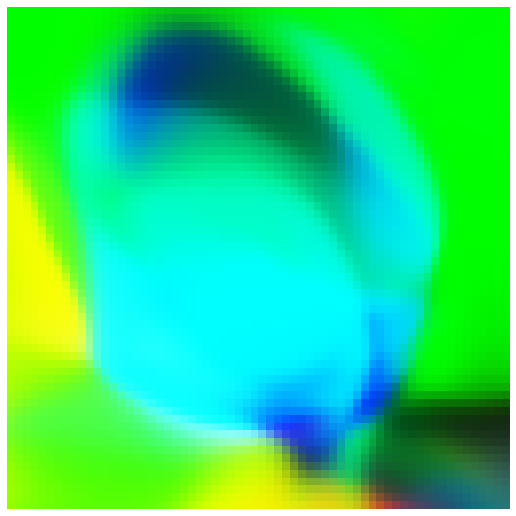

In [8]:
cppn.reinit()
scale = 1
zscale = 1
res = 64
z = torch.randn(1, dim_z).cuda() * zscale
x = sampler.generate_img(cppn, z, scale=scale, res=res)
sampler.imshow(x[:, :, :3])

# Test

In [9]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

450


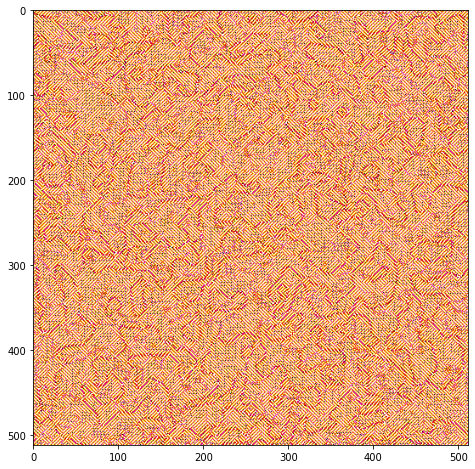

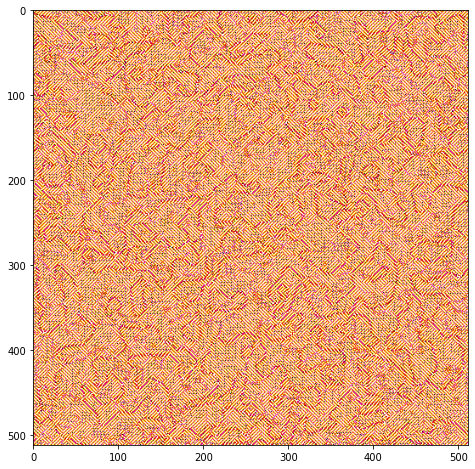

In [10]:
agent = 0
CA_run = population[agent]
CA_run.initGrid(BS=1)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 

cppn.reinit()
scale = 1
zscale = 1
z = torch.randn(1, dim_z).cuda() * zscale
x = sampler.generate_img(cppn, z, scale=scale, res=RES).transpose(2, 0, 1)

CA_run.psi = torch.cuda.FloatTensor(x).unsqueeze(0)

imgs = []

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [3]:
population = [CA().cuda() for i in range(POP)]
timestr = time.strftime("%Y%m%d-%H%M%S")
name_tag = '-margin=1.25'
name = f'model_p{int(len(population))}' + name_tag
PATH = 'models/' + name + '_' + timestr

if not path.exists(PATH):
    makedirs(PATH)

# for i in range(1,len(population)):
#     population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
#     population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
#     population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
#     population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
#     population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
#     population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()


embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss(margin=TRIPLET_MARGIN)
margin = MINE_MARGIN_INIT

CBS = 10 # should be even number
# EBS = 15
# ESTEPS = 25
EBS = 5  # scaled by population size?
ESTEPS = 100


writer = SummaryWriter(log_dir='runs/' + name + '_' + timestr)
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            K = np.random.randint(25, 50)
            for j in range(K):
                ca.forward()
                
            x = []
            for j in range(E_INDIM):
                x.append(ca.psi[:,0:1,:,:])
                ca.forward()
            x = torch.cat(x,1)
            
            lzs.append(embed.forward(x).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    for i in range(ESTEPS):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs, margin)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

#                 K1 = np.random.randint(25, 50)
#                 K2 = np.random.randint(25, 50)
                
                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                    
                c1 = []
                for k in range(E_INDIM):
                    c1.append(CA1.psi[:,0:1,:,:])
                    CA1.forward()
                c1 = torch.cat(c1,1)
                
                for k in range(K2):
                    CA2.forward()

                c2 = []
                for k in range(E_INDIM):
                    c2.append(CA2.psi[:,0:1,:,:])
                    CA2.forward()
                c2 = torch.cat(c2,1)
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = c1[0].cpu().detach().numpy()
                im2 = c1[1].cpu().detach().numpy()
                im3 = c2[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)  # anchor 
            x2.append(im2)  # positive 
            x3.append(im3)  # negative
            h_loss.append(hard)  

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
    
    # incrementally increase HNM margin as HNM steps increase
    if hard_frac >= HNM_STEPS/2:
        margin = margin + 0.1
        
    if margin > TRIPLET_MARGIN:
        break
#     print(f'emb: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    for ii in range(len(population) // 2):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < HNM_STEPS:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 > -TRIPLET_MARGIN:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS//2)

#         S1 = np.random.randint(25, 50)
#         S2 = np.random.randint(25, 50)
        
        S1 = 25
        S2 = 25

        for k in range(S1):
            CA1.forward()
            
        c1 = []
        for k in range(E_INDIM):
            c1.append(CA1.psi[:,0:1,:,:])
            CA1.forward()
        c1 = torch.cat(c1,1)

        for k in range(S2):
            CA2.forward()
            
        c2 = []
        for k in range(E_INDIM):
            c2.append(CA2.psi[:,0:1,:,:])
            CA2.forward()
        c2 = torch.cat(c2,1)

        im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = Image.fromarray(im)
        
        im2 = CA2.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im2 = (255 * np.clip(im2, 0, 1)).astype(np.uint8)
        im2 = Image.fromarray(im2)
#         im = CA1.psi.detach().cpu().numpy()[0, 0:1, :, :].transpose(1, 2, 0) * 0.5 + 0.5
#         im = (im * 255).astype('uint8')
#         im = Image.fromarray(im, 'RGB')
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr + name_tag, 'CA', 'CA_' + str(i).zfill(5)) # images saved according to CA
        fpath2 = path.join('frames', timestr + name_tag, 'CA', 'CA_' + str(j).zfill(5)) 
        fpath_epoch = path.join('frames', timestr + name_tag, 'all', 'epoch_' + str(epoch).zfill(3)) # images saved according to epoch
        if not path.exists(fpath):
            makedirs(fpath)
        if not path.exists(fpath2):
            makedirs(fpath2)
        if not path.exists(fpath_epoch):
            makedirs(fpath_epoch)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im.save(path.join(fpath_epoch, 'CA_' + str(i).zfill(5) + '.png'))
        im2.save(path.join(fpath2, str(j).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im2.save(path.join(fpath_epoch, 'CA_' + str(j).zfill(5) + '.png'))
        
        z1 = embed.forward(c1)
        z3 = embed.forward(c2)

        z2 = z1[CBS//2:]
        z1 = z1[:CBS//2]

        loss = tloss(z1,z2,z3)
        
        for CA in population:
            for p in CA.parameters():
                if p.grad is not None:
                    p.grad = p.grad / (1e-8 + torch.norm(p.grad))
        
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
#     print(f'CA_loss: {ca_err[-1]}')
    writer.add_scalar('Loss/CA', ca_err[-1], epoch)
    writer.add_scalar('Loss/Emb', emb_err[-1], epoch)
    writer.add_scalar('HNM/steps', hard_frac[-1], epoch)
    writer.add_scalar('HNM/margin', margin, epoch)

    np.savetxt(PATH + '/embed.txt', np.array(emb_err))
    np.savetxt(PATH + '/ca.txt', np.array(ca_err))
    np.savetxt(PATH + '/hard.txt', np.array(hard_frac))

stats = {
    'emb_loss': emb_err,
    'ca_loss': ca_err,
    'hard': hard_frac    
}

torch.save({
    'epoch': epoch,
    'model_state_dict': [CA.state_dict() for CA in population],
    'embedder_state_dict': embed.state_dict(),
    'embedder_optimizer_state_dict': e_optim.state_dict(),
    'stats': stats
}, PATH + '/' + name)

Epoch: 0
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 1
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 2
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 3
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 4
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 5
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 6
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 7
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 8
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 9
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 10
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 11
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 12
Generating embeddings for CAs...
Training embedder
Training CAs
Epoch: 13
Generating embeddings for CAs...
Train

In [ ]:
stats = {
    'emb_loss': emb_err,
    'ca_loss': ca_err,
    'hard': hard_frac    
}

torch.save({
    'epoch': epoch,
    'model_state_dict': [CA.state_dict() for CA in population],
    'embedder_state_dict': embed.state_dict(),
    'embedder_optimizer_state_dict': e_optim.state_dict(),
    'stats': stats
}, PATH + '/' + name)

# Embedding distances

In [9]:
POP = 100
population = [CA().cuda() for i in range(POP)]
embed = Embedder().cuda()

In [66]:
from scipy.spatial.distance import cdist as cdist

print('Generating embeddings')
batch_size = 4

# generate embeddings
zs = []
with torch.no_grad():
    for ca in tqdm(population):
        lzs = []
        ca.initGrid(batch_size)
        K = np.random.randint(25, 50)
        for j in range(K):
            ca.forward()

        x = []
        for j in range(E_INDIM):
            x.append(ca.psi[:,0:1,:,:])
            ca.forward()
        x = torch.cat(x,1)

        lzs.append(embed.forward(x).cpu().detach().numpy())
        # lxs.append(ca.psi.cpu().detach().numpy())
        zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
        ca.cleanup()
    zs = np.concatenate(zs, axis=0)    

  2%|▏         | 2/100 [00:00<00:05, 16.54it/s]

Generating embeddings


100%|██████████| 100/100 [00:03<00:00, 26.17it/s]


In [67]:
# calculate distances

d11s = []
d12s = []
for i in range(POP):
    
    d11 = cdist(zs[i], zs[i])
    d11 = d11[np.triu_indices(batch_size, k=1)]
    
    d11s.append(d11)
    
    for j in range(i, POP):

        d12 = cdist(zs[i], zs[j])
        d12 = d12[np.triu_indices(batch_size, k=1)]


        d12s.append(d12)

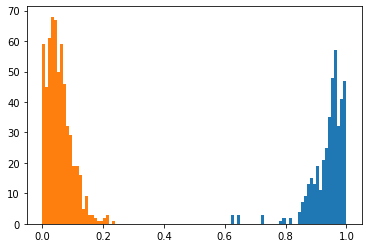

In [68]:
plt.hist(np.concatenate(d12s), 100, range=[0, 1]);
plt.hist(np.concatenate(d11s), 100, range=[0, 1]);

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def load_model(name):
    folder = 'models/' + name + '/'
    er = np.loadtxt(folder + 'embed.txt')
    cr = np.loadtxt(folder + "ca.txt")
    h = np.loadtxt(folder + "hard.txt")
    
    return er, cr, h

def make_figs(er, cr, h):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(h, '.')
    ax[0].set_title('Avg. Hard-negative mining steps')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Steps')

    ax[1].plot(er, '.', label='Embedder')
    ax[1].plot(cr, '.', label='CA')
    ax[1].set_title('CA and Discriminator triplet loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Tloss')
    plt.legend()

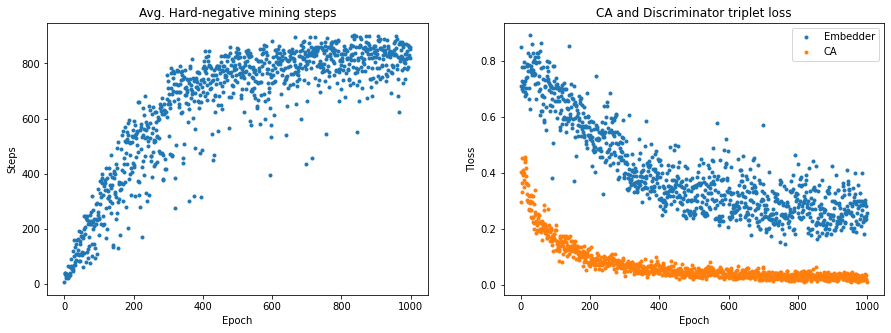

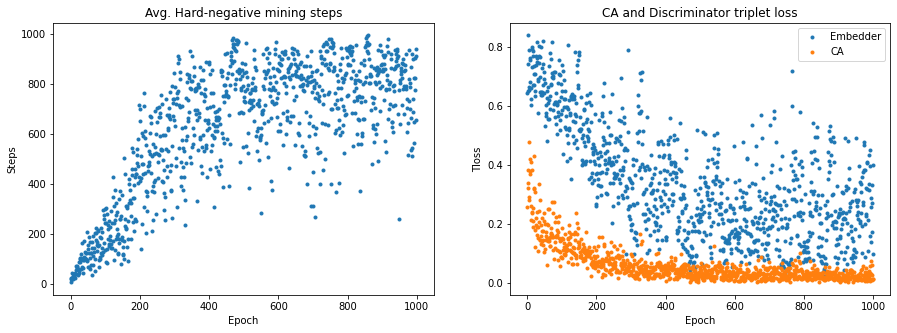

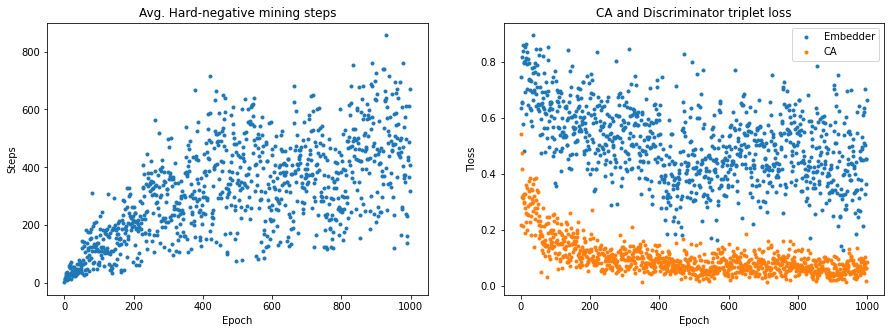

In [59]:
name = 'model_p500_20200825-152225'
make_figs(*load_model(name))

name = 'model_p100_20200824-192902'
make_figs(*load_model(name))

name = 'model_p100_20200826-200433'
make_figs(*load_model(name))


# Load

In [63]:
# name = 'models/model_p500-classic-3000hnms_20200902-025456/model_p500-classic-3000hnms'
name = 'models/model_p100-margin=1.25-scheduled-hnmmargin_20201024-020513/model_p100-margin=1.25-scheduled-hnmmargin'
loadfile = torch.load(name)

In [64]:
state_dicts = loadfile['model_state_dict']

In [65]:
population = [CA().cuda() for i in range(POP)]
for i, ca in enumerate(population):
    ca.load_state_dict(state_dicts[i])

embed = Embedder().cuda()
embed.load_state_dict(loadfile['embedder_state_dict'])

<All keys matched successfully>

In [ ]:
agent = 1
CA_run = population[agent]
CA_run.initGrid(BS=5)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
# CA_run.psi = x

imgs = []

zs = []
xs = []
count = 0

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)
        
        
        if count != 3:
            xs.append(CA_run.psi[:, 0:1, :, :])
            count += 1
        else:
            xs = torch.cat(xs, 1)
            zs.append(embed.forward(xs))
            count = 0
            xs = []

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

# fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

# for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
#     out.write(img)
# out.release()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


In [ ]:
zs_cpu = [z.cpu().numpy() for z in zs[25:]]
zs_cpu = np.concatenate(zs_cpu)
X = pca.fit_transform(zs_cpu)
c = np.arange(0, X.shape[0])

In [ ]:
plt.figure(figsize=(16, 6))
X = X.reshape((-1, 30, 2))
for i in range(30):
    plt.plot(X[:, i, 0], X[:, i, 1])
# plt.scatter(X[:, 0], X[:, 1], s=5, c=c)
# plt.colorbar()

In [19]:
population = [CA().cuda() for i in range(POP)]
for i, ca in enumerate(population):
    ca.load_state_dict(state_dicts[i])

embed = Embedder().cuda()
embed.load_state_dict(loadfile['embedder_state_dict'])

<All keys matched successfully>

450


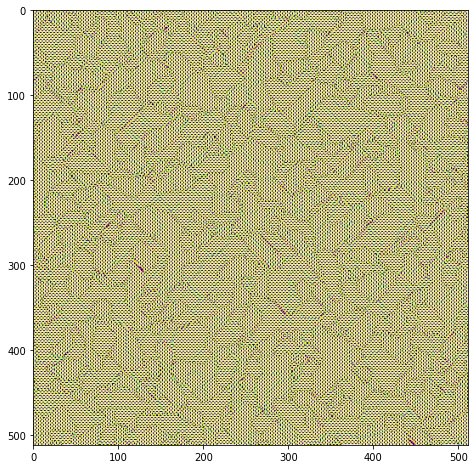

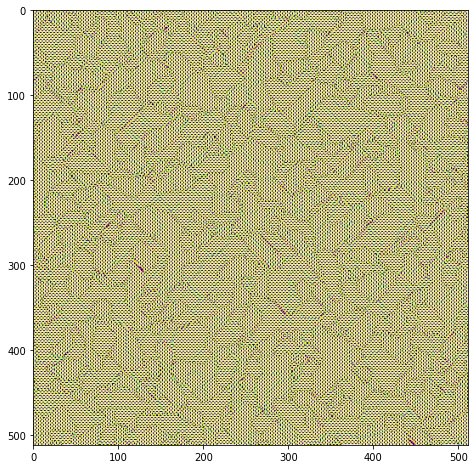

In [144]:
agent = 1
CA_run = population[agent]
CA_run.initGrid(BS=5)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.9999).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
# CA_run.psi = x

imgs = []

zs = []
xs = []
count = 0

timeSteps = 500

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)
        
        
        if count != 3:
            xs.append(CA_run.psi[:, 0:1, :, :])
            count += 1
        else:
            xs = torch.cat(xs, 1)
            zs.append(embed.forward(xs))
            count = 0
            xs = []

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

# fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

# for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
#     out.write(img)
# out.release()

In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)


In [143]:
zs_cpu = [z.cpu().numpy() for z in zs[25:]]
zs_cpu = np.concatenate(zs_cpu)
X = pca.fit_transform(zs_cpu)
c = np.arange(0, X.shape[0])

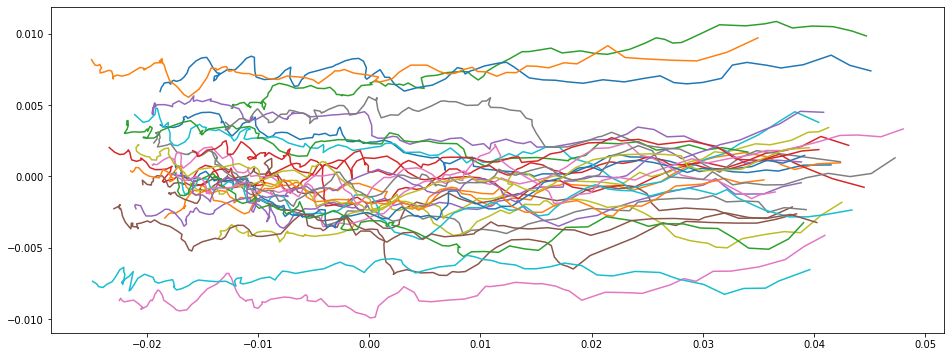

In [141]:
plt.figure(figsize=(16, 6))
X = X.reshape((-1, 30, 2))
for i in range(30):
    plt.plot(X[:, i, 0], X[:, i, 1])
# plt.scatter(X[:, 0], X[:, 1], s=5, c=c)
# plt.colorbar()

# UMAP

In [ ]:
import umap

In [ ]:
ZS = zs.reshape(-1, 16)
labels = np.tile(np.arange(0, 100), (1, 10)).reshape(10, 100).transpose().reshape(-1)

In [ ]:
ZS = ZS[0:10]
labels = labels[0:10]

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(ZS)

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=30, alpha=0.3, cmap='Spectral');

In [7]:
import umap

In [71]:
ZS = zs.reshape(-1, 16)
labels = np.tile(np.arange(0, 100), (1, 10)).reshape(10, 100).transpose().reshape(-1)

In [69]:
ZS = ZS[0:10]
labels = labels[0:10]

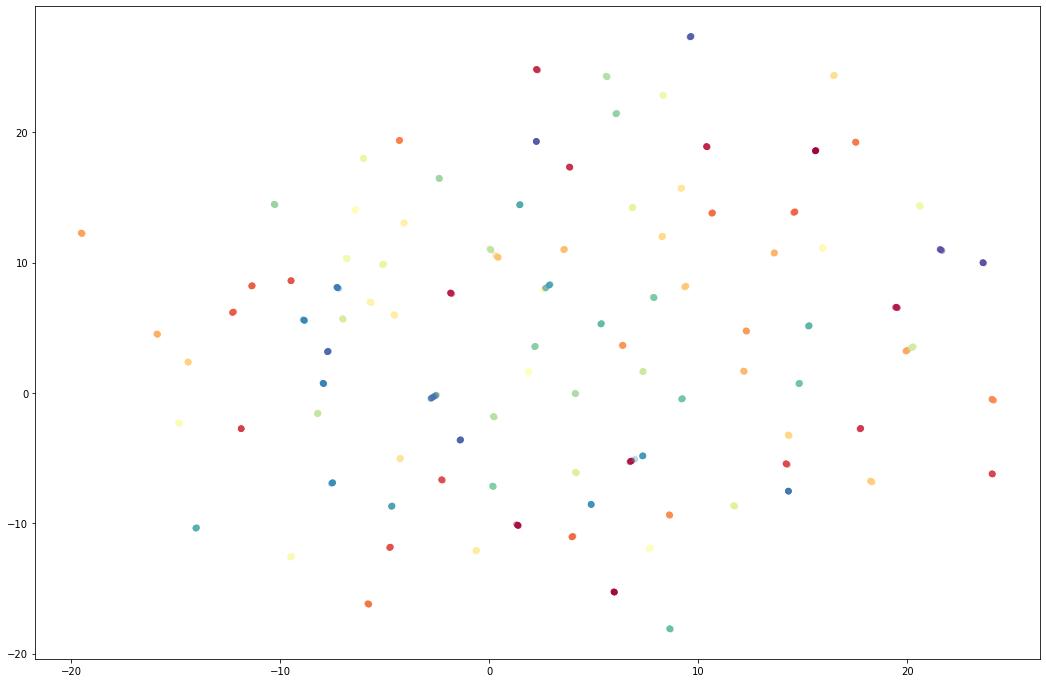

In [72]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(ZS)

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=30, alpha=0.3, cmap='Spectral');